<a href="https://colab.research.google.com/github/MinjuKim0217/Machine_Learning_Paper_Review/blob/main/AlexNet/AlexNet_Implementation_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

# Load Dataset
The CIFAR-10 dataset

60,000개의 이미지, 32x32px.

10개의 class

In [2]:
(train_images, train_labels), (test_images, test_labels)= keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
# class 이름 붙여주기
CLASS_NAMES=['airplanes', 'automobile', 'bird','cat','deer','dog','frog','horse','ship','truck']

validation data 따로 나눠주기

CIFAR dataset은 50,000 training data, 10,000 test data가 있다. (default)
5000개 데이터 validation data로

In [4]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

In [5]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))
validation_ds=tf.data.Dataset.from_tensor_slices((validation_images,validation_labels))

# Preprocessing

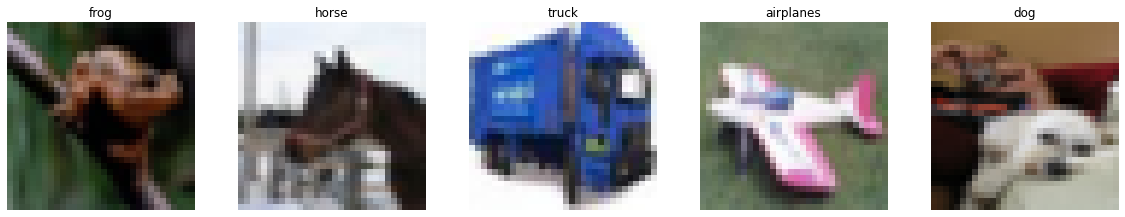

In [6]:
plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(train_ds.take(5)):
  ax=plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(CLASS_NAMES[label.numpy()[0]])
  plt.axis('off')

먼저 해야 할 전처리
- normaliaing, standardizing 
- 32x32 이미지 227x227 이미지로 변환



In [7]:
#preprocess 하는 함수
def process_images(image, label):
  #Normalize images to have a mean of 0 and standard deviation of 1
  image=tf.image.per_image_standardization(image)
  #Resize images from 32x32 to 227x227
  image=tf.image.resize(image,(227,227))
  return image, label

# Data/Input Pipline

나누어진 데이터셋의 크기는 반드시 알아놔야 한다. 왜냐하면 나중에 네트워크에 들어가기 전에 충분히 잘 shuffle 되었는지 확인하기 위해!




In [8]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size=tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


파이프라인 구축 전 해야할 것

1. 데이터셋 내에서 데이터 전처리
2. 데이터셋 shuffle
3. 데이터셋 내의 데이터들 배치로 나누기

In [9]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

# Model Implementation

In [10]:
# keras implementation of the AlexNet CNN architecture

model= keras.models.Sequential([
                                keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu',input_shape=(227,227,3)),
                                keras.layers.BatchNormalization(),
                                keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
                                keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'),
                                keras.layers.BatchNormalization(),
                                keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
                                keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'),
                                keras.layers.BatchNormalization(),
                                keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
                                keras.layers.Flatten(),
                                keras.layers.Dense(4096, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(4096, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(10, activation='softmax')

])

In [11]:
#Tensorboard

root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# Training and Results

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.fit(train_ds,
          epochs=10,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/10
 594/1406 [===========>..................] - ETA: 9:22 - loss: 2.4016 - accuracy: 0.3034